In [109]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../..')
%load_ext autoreload
from JKBio import Helper as h
%autoreload 2
%load_ext rpy2.ipython
import numpy as np
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from JKBio.helper import pyDESeq2 as pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [ ]:
! mkdir ../../data/slam/MYCpaper && cd ../../data/slam/MYCpaper && fastq_dump SRR5806781 && fastq_dump SRR5806783 && fastq_dump SRR5806785 &&
fastq_dump SRR5806780 && fastq_dump SRR5806782 && fastq_dump SRR5806784 && cd -

In [ ]:
ls ../../data/slam/MYCpaper

In [ ]:
folder_bams = "../../data/slam/MYCpaper/"
bams = ! ls $folder_bams
bams

In [ ]:
! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
for val in bams[1:]:
    print(val)
    os.system('../../TrimGalore-0.6.5/trim_galore -stringency 3 \
    --illumina '+folder_bams+val + ' -o '+folder_bams) 

In [ ]:
ls -al ../../data/slam/res/count

In [ ]:
for val in bams[1:]:
    print(val)
    os.system('slamdunk all -r ../../data/slam/ref_genome.fa -b ../../data/slam/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed \
    -o ../../data/slam/res/ -t 8 -c 2 '+folder_bams+val.split('.')[0]+'_trimmed.fq')

In [ ]:
ls -al ../../data/slam/res/filter

In [ ]:
for val in bams[1:]:
    print(val)
    os.system('slamdunk count -r ../../data/slam/ref_genome.fa \
    -b ../../data/slam/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed \
    -o ../../data/slam/res/count/ -t 8 -c 2 -s ../../data/slam/res/snp \
    ../../data/slam/res/filter/'+ val.split('.')[0]+"_trimmed_slamdunk_mapped_filtered.bam")

# we first need to recreate out RNA matrix from slamdunk's tcount files

In [23]:
#location= '../../data/slam/resMYCpaper/count/*.tsv' # ../data/slamseq_data/
location= '../data/MOLM13_slamseq_mycpaper/*.tsv'

In [24]:
files = ! ls $location
files

['../data/MOLM13_slamseq_mycpaper/GSM2691882_Sample35_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691883_Sample36_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691884_Sample37_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691885_Sample38_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691886_Sample39_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691887_Sample40_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691888_Sample41_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691889_Sample42_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691890_Sample43_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691891_Sample44_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691892_Sample45_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691893_Sample46_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691894_Sample47_tcount.tsv',
 '../data/MOLM13_slamseq_mycpaper/GSM2691895_Sample48_tcount.tsv']

In [25]:
data={}
for file in files:
    data[file.split('/')[-1].split('_')[0]]= pd.read_csv(file, sep='\t', comment='#',header=0)

In [26]:
prev = -2
for k,val in data.items():
    if len(set(val.Name)) != prev and prev!=-2: 
        raise ValueError('we do not have the same number of genes in each file')
    prev = len(set(val.Name))

![](images/conversionrates.png)

In [27]:
data.keys()

dict_keys(['GSM2691882', 'GSM2691883', 'GSM2691884', 'GSM2691885', 'GSM2691886', 'GSM2691887', 'GSM2691888', 'GSM2691889', 'GSM2691890', 'GSM2691891', 'GSM2691892', 'GSM2691893', 'GSM2691894', 'GSM2691895'])

In [28]:
val

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.000000,112,0,0,0,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.002143,32.356659,242,9801,21,491,7,0,-1.0,-1.0
2,chr12,109448654,109451813,83892,3159,-,0.003422,10.807519,921,3507,12,164,6,0,-1.0,-1.0
3,chr12,109456117,109456313,83892,196,-,0.000000,0.000000,57,0,0,0,0,0,-1.0,-1.0
4,chr12,109457629,109457682,83892,53,-,0.000000,0.000000,10,0,0,0,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58131,chr1,46691873,46692098,100130197,225,+,0.000000,0.000000,61,0,0,0,0,0,-1.0,-1.0
58132,chr2,101151659,101152759,100506286,1100,+,0.000000,0.197699,191,33,0,3,0,0,-1.0,-1.0
58133,chr2,101154034,101155412,100506286,1378,+,0.000000,0.000000,337,0,0,0,0,0,-1.0,-1.0
58134,chrX,106639813,106639896,100616144,83,+,0.000000,0.000000,25,0,0,0,0,0,-1.0,-1.0


In [29]:
flag_var= 100

readcounts = {i:[0]*len(data) for i in val.Name.unique()}
tccounts = {i:[0]*len(data) for i in val.Name.unique()}

In [30]:
for n, (_,val) in enumerate(data.items()):
    val = val.sort_values(by="Name")
    j  = 0
    #print('              ',end='\r')
    readcount = [val.iloc[0].ReadCount]
    tccount = [val.iloc[0].TcReadCount]
    prevname = val.iloc[0].Name
    for _, v in val.iloc[1:].iterrows():
        if v.Name==4609:
            print(v.ReadCount,v.TcReadCount)
            print(readcount,tccount)
        if v.Name == prevname:
            readcount.append(v.ReadCount)
            tccount.append(v.TcReadCount)
        else:
            readcounts[prevname][n] = np.sum(readcount)
            tccounts[prevname][n] = np.sum(tccount)
            #if np.var(readcount) > flag_var:
            #    print("pb with "+str(v.Name))
            prevname=v.Name
            j+=1
            #print(j,end='\r')
            readcount = [v.ReadCount]
            tccount = [v.TcReadCount]
            
files = [*data]

338 169
[720, 0] [7, 0]
140 89
[751, 0] [3, 0]
163 93
[524, 0] [1, 0]
37 15
[696, 0] [0, 0]
22 19
[366, 0] [1, 0]
50 29
[750, 0] [1, 0]
114 60
[670, 0] [0, 0]
49 17
[637, 0] [5, 0]
365 171
[854, 4] [19, 0]
77 18
[595, 0] [1, 0]
143 37
[790, 2] [0, 0]
11 1
[1147, 0] [0, 0]
38 3
[802, 0] [0, 0]
8 0
[715, 0] [0, 0]


In [31]:
val.Name

35944            1
14222            2
42459            3
42460            3
42452            3
           ...    
33888    107282092
8628     107303344
7168     107397392
43745    107399301
43744    107399303
Name: Name, Length: 58136, dtype: int64

In [32]:
files

['GSM2691882',
 'GSM2691883',
 'GSM2691884',
 'GSM2691885',
 'GSM2691886',
 'GSM2691887',
 'GSM2691888',
 'GSM2691889',
 'GSM2691890',
 'GSM2691891',
 'GSM2691892',
 'GSM2691893',
 'GSM2691894',
 'GSM2691895']

In [33]:
readcounts[4609]

[338, 140, 163, 37, 22, 50, 114, 49, 365, 77, 143, 11, 38, 8]

In [34]:
readcounts = pd.DataFrame(data=readcounts,columns=val.Name.unique(),index=data.keys()).T
tccounts = pd.DataFrame(data=tccounts,columns=val.Name.unique(),index=data.keys()).T

In [35]:
readcounts.loc[4609]

GSM2691882    338
GSM2691883    140
GSM2691884    163
GSM2691885     37
GSM2691886     22
GSM2691887     50
GSM2691888    114
GSM2691889     49
GSM2691890    365
GSM2691891     77
GSM2691892    143
GSM2691893     11
GSM2691894     38
GSM2691895      8
Name: 4609, dtype: int64

In [36]:
names, _ = h.convertGenes(readcounts.index.tolist(), from_idtype="entrez_id", to_idtype="symbol")
readcounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [37]:
names, _ = h.convertGenes(tccounts.index.tolist(), from_idtype="entrez_id", to_idtype="symbol")
tccounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [38]:
todrop=np.argwhere(tccounts.values.max(1)>0).ravel()
tccounts = tccounts.iloc[todrop]
readcounts = readcounts.iloc[todrop]

In [39]:
todrop=np.argwhere(readcounts.values.max(1)>=10).ravel()
tccounts = tccounts.iloc[todrop]
readcounts = readcounts.iloc[todrop]

In [41]:
rename = {"GSM2691882": "MOLM-13_DMSO_rep-1_exp-2",
"GSM2691883": "MOLM-13_DMSO_rep-2_exp-2",
"GSM2691884": "MOLM-13_DMSO_rep-3_exp-2",
"GSM2691885": "MOLM-13_JQ1_rep-1_exp-2",
"GSM2691886": "MOLM-13_JQ1_rep-2_exp-2",
"GSM2691887": "MOLM-13_JQ1_rep-3_exp-2",
"GSM2691888": "MOLM-13_6nM_NVP-2_rep-1_exp-2",
"GSM2691889": "MOLM-13_6nM_NVP-2_rep-2_exp-2",
"GSM2691890": "MOLM-13_6nM_NVP-2_rep-3_exp-2",
"GSM2691891": "MOLM-13_60nM_NVP-2_rep-1_exp-2",
"GSM2691892": "MOLM-13_60nM_NVP-2_rep-2_exp-2",
"GSM2691893": "MOLM-13_JQ1+6nM_NVP-2_rep-1_exp-2",
"GSM2691894": "MOLM-13_JQ1+6nM_NVP-2_rep-2_exp-2",
"GSM2691895": "MOLM-13_JQ1+6nM_NVP-2_rep-3_exp-2"}

In [43]:
tccounts = tccounts.rename(columns=rename)
readcounts = readcounts.rename(columns=rename)

In [ ]:
tccounts = tccounts.apply(lambda x: x+1)

## SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

In [ ]:
tccounts

# lets look at the similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [ ]:
tccounts.columns

In [ ]:
sorting = [0,1,2,3,4,5,6,8,10,7,9,11,12,13,14]

In [ ]:
tccounts.columns[sorting]

In [ ]:
tccounts = tccounts[tccounts.columns[sorting]]

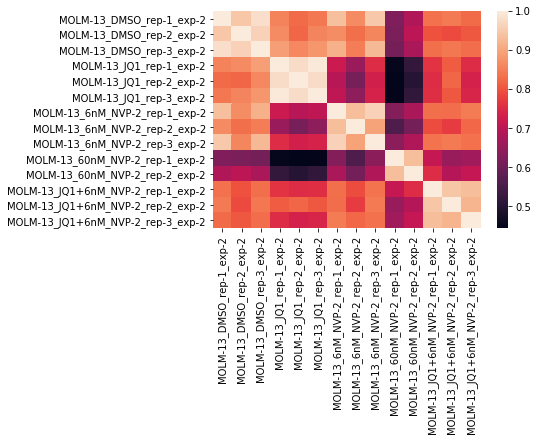

In [44]:
%matplotlib inline
sns.heatmap(tccounts.corr(), 
            xticklabels=tccounts.columns.values,
            yticklabels=tccounts.columns.values)

In [ ]:
readcounts = readcounts[readcounts.columns[sorting]]

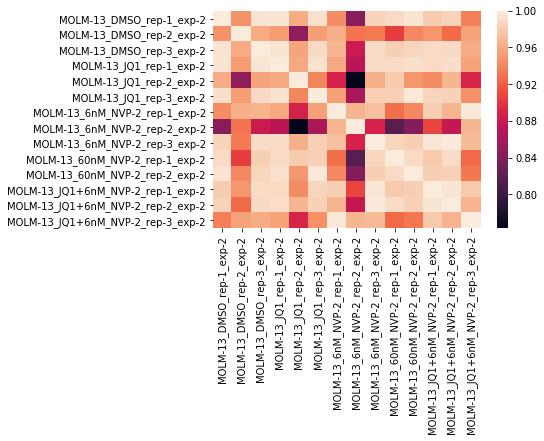

In [45]:
%matplotlib inline
sns.heatmap(readcounts.corr(), 
            xticklabels=readcounts.columns.values,
            yticklabels=readcounts.columns.values)

we can see that for MOLM13 there is a stronger batch effect than condition effect

### A quick detour to look for clustering

## Getting the Core TF information

In [120]:
ctf=pd.read_csv('../data/CTF.csv',header=None)[0].values.tolist()
ctf

['ARID2',
 'CEBPA',
 'CEBPE',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'GFI1B',
 'HHEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MTF1',
 'MYB',
 'MYC',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SETDB1',
 'SNAPC5',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TERF2',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZMYND8',
 'LMO2',
 'MAX',
 'ELF2',
 'ETV6',
 'HOXA9',
 'GATA2']

In [123]:
set(ctf) & set(tccounts.genes)

{'ARID2',
 'CEBPA',
 'CEBPE',
 'E2F3',
 'ELF2',
 'ETV6',
 'FLI1',
 'FOSL2',
 'GATA2',
 'GFI1',
 'HHEX',
 'HOXA9',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MTF1',
 'MYB',
 'MYC',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SETDB1',
 'SNAPC5',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TERF2',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZMYND8'}

## saving median mean and values

In [51]:
!mkdir ../results/MYCpaper_vMOLM13/

In [52]:
readcounts.to_csv('../results/MYCpaper_vMOLM13/readcounts.csv')
tccounts.to_csv('../results/MYCpaper_vMOLM13/tccounts.csv')

In [57]:
cols = list(set([i.split('_rep')[0] for i in tccounts.columns]))
cols

['MOLM-13_DMSO',
 'MOLM-13_JQ1+6nM_NVP-2',
 'MOLM-13_6nM_NVP-2',
 'MOLM-13_60nM_NVP-2',
 'MOLM-13_JQ1']

In [64]:
meantc = pd.DataFrame()
for val in cols:
    meantc[val] = tccounts[[i for i in tccounts.columns if val in i]].mean(1)
meanread = pd.DataFrame()
for val in cols:
    meanread[val] = readcounts[[i for i in readcounts.columns if val in i]].mean(1)
medread = pd.DataFrame()
for val in cols:
    medread[val] = readcounts[[i for i in readcounts.columns if val in i]].median(1)
medtc = pd.DataFrame()
for val in cols:
    medtc[val] = tccounts[[i for i in tccounts.columns if val in i]].median(1)

In [66]:
medtc.to_csv('../results/MYCpaper_vMOLM13/medtc.csv')
meantc.to_csv('../results/MYCpaper_vMOLM13/meantc.csv')
medread.to_csv('../results/MYCpaper_vMOLM13/medread.csv')
meanread.to_csv('../results/MYCpaper_vMOLM13/meanread.csv')

# Let's look at how they change accross time

how core transcription factors change accross time when the cell is with JQ1 conditions

we are looking at the difference between production of each CTF compared to the average RNA production with JQ1 and without JQ1

## DESEQ ANALYSIS

In [67]:
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)
tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [68]:
tccounts.iloc[140]

MOLM-13_DMSO_rep-1_exp-2                4
MOLM-13_DMSO_rep-2_exp-2                0
MOLM-13_DMSO_rep-3_exp-2                2
MOLM-13_JQ1_rep-1_exp-2                 7
MOLM-13_JQ1_rep-2_exp-2                 7
MOLM-13_JQ1_rep-3_exp-2                13
MOLM-13_6nM_NVP-2_rep-1_exp-2          10
MOLM-13_6nM_NVP-2_rep-2_exp-2           1
MOLM-13_6nM_NVP-2_rep-3_exp-2           3
MOLM-13_60nM_NVP-2_rep-1_exp-2          0
MOLM-13_60nM_NVP-2_rep-2_exp-2          0
MOLM-13_JQ1+6nM_NVP-2_rep-1_exp-2      14
MOLM-13_JQ1+6nM_NVP-2_rep-2_exp-2       2
MOLM-13_JQ1+6nM_NVP-2_rep-3_exp-2       1
genes                                ARAF
Name: 140, dtype: object

In [76]:
tccounts.columns.tolist()

['MOLM-13_DMSO_rep-1_exp-2',
 'MOLM-13_DMSO_rep-2_exp-2',
 'MOLM-13_DMSO_rep-3_exp-2',
 'MOLM-13_JQ1_rep-1_exp-2',
 'MOLM-13_JQ1_rep-2_exp-2',
 'MOLM-13_JQ1_rep-3_exp-2',
 'MOLM-13_6nM_NVP-2_rep-1_exp-2',
 'MOLM-13_6nM_NVP-2_rep-2_exp-2',
 'MOLM-13_6nM_NVP-2_rep-3_exp-2',
 'MOLM-13_60nM_NVP-2_rep-1_exp-2',
 'MOLM-13_60nM_NVP-2_rep-2_exp-2',
 'MOLM-13_JQ1+6nM_NVP-2_rep-1_exp-2',
 'MOLM-13_JQ1+6nM_NVP-2_rep-2_exp-2',
 'MOLM-13_JQ1+6nM_NVP-2_rep-3_exp-2',
 'genes']

In [ ]:
tccounts.columns = [i.replace('-','.') for i in tccounts.columns]

In [75]:
len(tccounts.columns)

15

In [88]:
design1 = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','JQ1'], 
                      data=np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,1,1,1,0,0,0,0,0,0,0,0]],dtype=bool).T)
design2 = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','NVP2low'], 
                      data=np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,1,1,0,0,0,0,0]],dtype=bool).T)
design3 = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','NVP2high'], 
                      data=np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,1,0,0,0]],dtype=bool).T)
design4 = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','NVP2lowJQ1'], 
                      data=np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,1,1,1]],dtype=bool).T)

### Differential gene expression analysis, PCA and GO-term enrichment

For gene-level analysis, raw reads mapped to different UTR annotations of the same gene were summed up by Entrez Gene ID. Pilot studies of K562 cells with kinase inhibitors were performed as single experiments. 

Analysis of differential gene expression was restricted to genes with ≥ 10 reads in at least one condition for 50bp sequencing runs (flavopiridol and DMSO) or ≥ 20 reads in at least one condition for 100bp sequencing runs (mk2206, trametinib, nilotinib, trametinib + mk2206 and DMSO). For estimating differential expression, a pseudo-count of 1 raw read was added to all genes.

#### All other SLAM-seq experiments were performed in triplicates and analyzed as follows. 
Differential gene expression calling was performed on raw read counts with ≥ 2 T>C conversions using DESeq2 (version 1.14.1) with default settings, and with size factors estimated on corresponding total mRNA reads for global normalization.

Downstream analysis was restricted to genes passing all internal filters for FDR estimation by DESeq2. Principal component analysis was performed after variance
stabilizing transformation on the 500 most variable genes across all conditions of a given
experiment. GO-term enrichment analysis was performed on genes significantly and strongly downregulated (FDR ≤ 0.1, log2FC ≤ -1) in SLAM-seq upon IAA-treatment in K562MYC-AID + Tir1 by the PANTHER Overrepresentation Test (Fisher's Exact with FDR multiple test correction, release 20171205, http://pantherdb.org) on GO Ontology database Released 2017-12-27.

In [89]:
design4

,DMSO,NVP2lowJQ1
MOLM.13_DMSO_rep.1_exp.2,True,False
MOLM.13_DMSO_rep.2_exp.2,True,False
MOLM.13_DMSO_rep.3_exp.2,True,False
MOLM.13_JQ1_rep.1_exp.2,False,False
MOLM.13_JQ1_rep.2_exp.2,False,False
MOLM.13_JQ1_rep.3_exp.2,False,False
MOLM.13_6nM_NVP.2_rep.1_exp.2,False,False
MOLM.13_6nM_NVP.2_rep.2_exp.2,False,False
MOLM.13_6nM_NVP.2_rep.3_exp.2,False,False
MOLM.13_60nM_NVP.2_rep.1_exp.2,False,False


In [82]:
tccounts[tccounts.genes=='MYC']

,MOLM.13_DMSO_rep.1_exp.2,MOLM.13_DMSO_rep.2_exp.2,MOLM.13_DMSO_rep.3_exp.2,MOLM.13_JQ1_rep.1_exp.2,MOLM.13_JQ1_rep.2_exp.2,MOLM.13_JQ1_rep.3_exp.2,MOLM.13_6nM_NVP.2_rep.1_exp.2,MOLM.13_6nM_NVP.2_rep.2_exp.2,MOLM.13_6nM_NVP.2_rep.3_exp.2,MOLM.13_60nM_NVP.2_rep.1_exp.2,MOLM.13_60nM_NVP.2_rep.2_exp.2,MOLM.13_JQ1+6nM_NVP.2_rep.1_exp.2,MOLM.13_JQ1+6nM_NVP.2_rep.2_exp.2,MOLM.13_JQ1+6nM_NVP.2_rep.3_exp.2,genes
1575,169,89,93,15,19,29,60,17,171,18,37,1,3,0,MYC


In [91]:
deseq1 = pyDESeq2.pyDESeq2(count_matrix = tccounts[tccounts.columns[np.array([1,1,1,1,1,1,0,0,0,0,0,0,0,0,1],np.bool)]],
                         design_matrix=design1[np.array([1,1,1,1,1,1,0,0,0,0,0,0,0,0],np.bool)],
                         design_formula="~DMSO - JQ1",
                         gene_column="genes")
deseq2 = pyDESeq2.pyDESeq2(count_matrix = tccounts[tccounts.columns[np.array([1,1,1,0,0,0,1,1,1,0,0,0,0,0,1],np.bool)]],
                         design_matrix=design2[np.array([1,1,1,0,0,0,1,1,1,0,0,0,0,0],np.bool)],
                         design_formula="~DMSO - NVP2low",
                         gene_column="genes")
deseq3 = pyDESeq2.pyDESeq2(count_matrix = tccounts[tccounts.columns[np.array([1,1,1,0,0,0,0,0,0,1,1,0,0,0,1],np.bool)]],
                         design_matrix=design3[np.array([1,1,1,0,0,0,0,0,0,1,1,0,0,0],np.bool)],
                         design_formula="~DMSO - NVP2high",
                         gene_column="genes")
deseq4 = pyDESeq2.pyDESeq2(count_matrix = tccounts[tccounts.columns[np.array([1,1,1,0,0,0,0,0,0,0,0,1,1,1,1],np.bool)]],
                         design_matrix=design4[np.array([1,1,1,0,0,0,0,0,0,0,0,1,1,1],np.bool)],
                         design_formula="~DMSO - NVP2lowJQ1",
                         gene_column="genes")

3.2.6
3.2.6
3.2.6
3.2.6


In [ ]:
np.exp(np.mean(np.log(readcounts[readcounts.columns[np.array([1,1,1,1,1,1,0],np.bool)]].values+1), 1))

In [92]:
deseq1.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[np.array([0,0,0,1,1,1,0,0,0,0,0,0,0,0,0], np.bool)]].values+1), 1)))
deseq2.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[np.array([0,0,0,0,0,0,1,1,1,0,0,0,0,0,0], np.bool)]].values+1), 1)))
deseq3.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[np.array([0,0,0,0,0,0,0,0,0,1,1,0,0,0,0], np.bool)]].values+1), 1)))
deseq4.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1,0], np.bool)]].values+1), 1)))

In [94]:
deseq1.run_deseq()
deseq2.run_deseq()
deseq3.run_deseq()
deseq4.run_deseq()

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersio

In [95]:
deseq1.get_deseq_result()
deseq2.get_deseq_result()
deseq3.get_deseq_result()
deseq4.get_deseq_result()

In [97]:
res1 = deseq1.deseq_result
res2 = deseq2.deseq_result
res3 = deseq3.deseq_result
res4 = deseq4.deseq_result

In [98]:
res1.pvalue = np.nan_to_num(np.array(res1.pvalue), 1)
res1.log2FoldChange = np.nan_to_num(np.array(res1.log2FoldChange), 0)
res2.pvalue = np.nan_to_num(np.array(res2.pvalue), 1)
res2.log2FoldChange = np.nan_to_num(np.array(res2.log2FoldChange), 0)
res3.pvalue = np.nan_to_num(np.array(res3.pvalue), 1)
res3.log2FoldChange = np.nan_to_num(np.array(res3.log2FoldChange), 0)
res4.pvalue = np.nan_to_num(np.array(res4.pvalue), 1)
res4.log2FoldChange = np.nan_to_num(np.array(res4.log2FoldChange), 0)

In [99]:
res1[res1.genes=='MYC']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes
1575,64.771204,2.288025,0.31939,7.163728,7.851188e-13,3.089629e-10,MYC


In [100]:
res1.log2FoldChange = -res1.log2FoldChange
res2.log2FoldChange = -res2.log2FoldChange
res3.log2FoldChange = -res3.log2FoldChange
res4.log2FoldChange = -res4.log2FoldChange

In [101]:
res1["gene_id"] = res1.genes
res2["gene_id"] = res2.genes
res3["gene_id"] = res3.genes
res4["gene_id"] = res4.genes

# PLOTS

## Whiker plot

/home/jeremie/.local/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/jeremie/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'JQ1')

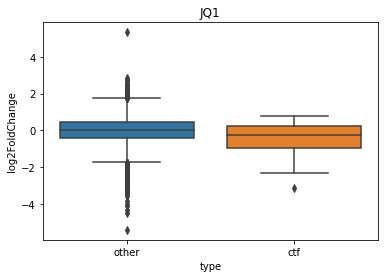

In [146]:
res = res1[res1.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['ctf' if i else "other" for i in  res.genes.isin(ctf)]
sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("JQ1")

Text(0.5, 1.0, 'JQ1')

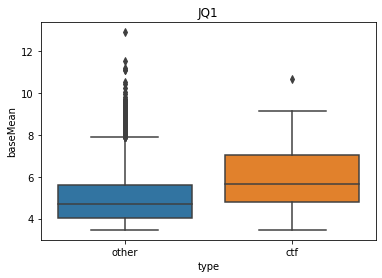

In [147]:
sns.boxplot(data=res,x='type',y='baseMean').set_title("JQ1")

/home/jeremie/.local/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/jeremie/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'NVP2low')

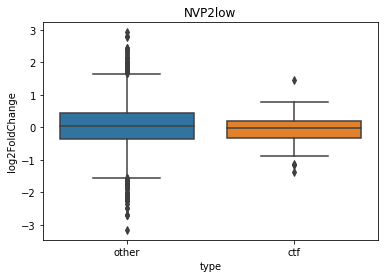

In [148]:
res = res2[res2.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['ctf' if i else "other" for i in  res.genes.isin(ctf)]
sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("NVP2low")

Text(0.5, 1.0, 'NVP2low')

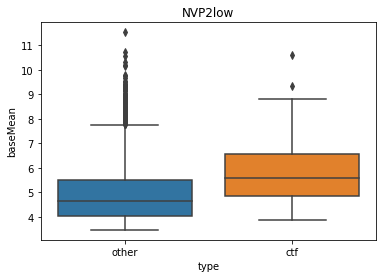

In [149]:
sns.boxplot(data=res,x='type',y='baseMean').set_title("NVP2low")

/home/jeremie/.local/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/jeremie/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'NVP2high')

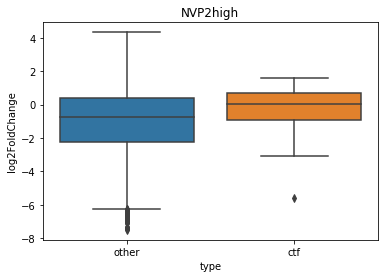

In [150]:
res = res3[res3.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['ctf' if i else "other" for i in  res.genes.isin(ctf)]
sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("NVP2high")

Text(0.5, 1.0, 'NVP2high')

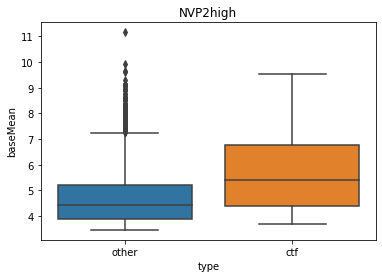

In [152]:
sns.boxplot(data=res,x='type',y='baseMean').set_title("NVP2high")

/home/jeremie/.local/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/jeremie/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'NVP2low+JQ1')

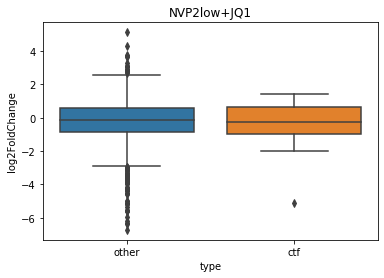

In [153]:
res = res4[res4.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['ctf' if i else "other" for i in  res.genes.isin(ctf)]
sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("NVP2low+JQ1")

Text(0.5, 1.0, 'NVP2low+JQ1')

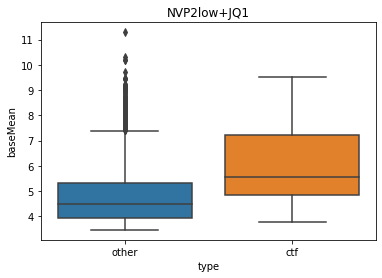

In [154]:
sns.boxplot(data=res,x='type',y='baseMean').set_title("NVP2low+JQ1")

## Volcano Plot

In [128]:
show(h.volcano(res1,tohighlight=ctf, searchbox=True, title="JQ1"))
show(h.volcano(res2,tohighlight=ctf, searchbox=True, title="NVP2low"))
show(h.volcano(res3,tohighlight=ctf, searchbox=True, title="NVP2hgih"))
show(h.volcano(res4,tohighlight=ctf, searchbox=True, title="NVP2low+JQ1"))

we can conclude that we get similar results to the slamseq myc paper although it seems that our values are a bit skewed toward higher expression than what is on the slamseq paper. It mightt be explained by the pseudo count of 1 that I did not set. Because I think it would highly bias the DESeq algorithm.

In [106]:
res1.to_csv("../results/MYCpaper_vMOLM13/jq1.csv")
res2.to_csv("../results/MYCpaper_vMOLM13/nvp2low.csv")
res3.to_csv("../results/MYCpaper_vMOLM13/nvp2high.csv")
res4.to_csv("../results/MYCpaper_vMOLM13/jq1&nvp2hlow.csv")